https://youtu.be/R-N-YXzvOmY

**Training Detectron2 for Nuclei segmentation in H&E-Stained Images** <br>

Train custom instance segmentation model using Detectron2 - on your own dataset.

<p>

This is part 1 of the two part tutorial on training custom nuclei model where we use Detectron2 (Mask R-CNN) for instance segmentation. Next part will use YOLOv8 for the same task.

<p>

This code is a complete project, with the following steps <br>

* Training Detectron2 model
* Verifying the training metrics and making sense of the numbers
* Testing the trained model on test dataset
* Extracting morphological measurements from the detected objects
* Plotting results

<p>

But first make sure you get your data ready for training. Please watch my video tutorial associated with this code to learn about downloading labeled masks and converting them to COCO JSON format.

<p>

**Nuclei dataset can be downloaded from:** https://www.kaggle.com/datasets/ipateam/nuinsseg?resource=download
<br>

**Dataset description:** https://arxiv.org/abs/2308.01760
<br>
<p>

**Summary of the dataset:** <p>
The NuInsSeg dataset contains more than *30k manually segmented nuclei from 31 human and mouse organs and 665 image patches extracted from H&E-stained whole slide images*. We also provide ambiguous area masks for the entire dataset to show in which areas manual semantic/instance segmentation were impossible.
<p>

**Human organs:**

cerebellum, cerebrum (brain), colon (rectum), epiglottis, jejunum, kidney, liver, lung, melanoma, muscle, oesophagus, palatine tonsil, pancreas, peritoneum, placenta, salivary gland, spleen, stomach (cardia), stomach (pylorus), testis, tongue, umbilical cord, and urinary bladder
<p>

**Mouse organs:**

cerebellum, cerebrum, colon, epiglottis, lung, melanoma, muscle, peritoneum, stomach (cardia), stomach (pylorus), testis, umbilical cord, and urinary bladder)

**Install Detectron2**

In [1]:
# !pip install "cython<3.0.0" && pip install --no-build-isolation pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
# !git clone https://github.com/facebookresearch/detectron2
# dist = distutils.core.run_setup("./detectron2/setup.py")
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Verify the torch and detectron versions

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Nov__3_17:51:05_Pacific_Daylight_Time_2023
Cuda compilation tools, release 12.3, V12.3.103
Build cuda_12.3.r12.3/compiler.33492891_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(1)
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 1
Count of using GPUs: 4


Import the required libraries

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib import pyplot as plt
from tqdm import tqdm

Register datasets in the COCO format. Let us register both the training and validation datasets. Please note that we are working with training (and validation) data that is is the COCO format where we have a single JSON file that describes all the annotations from all training images. <p>
Here, we are naming our training data as 'dataset_train' and the validation data as 'dataset_val'. Let us handle the test dataset later.



In [5]:
# show current DatasetCatalog
print(DatasetCatalog)

DatasetCatalog(registered datasets: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fi

In [6]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances("dataset_train",
                        {},
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train/coco_annotations.json",
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train"
                        )

register_coco_instances("dataset_val",
                        {},
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/val/coco_annotations.json", 
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/val"
                        )

register_coco_instances("dataset_test", 
                        {}, 
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/test/coco_annotations.json", 
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/test"
                        )



Let us extract the metadata and dataset dictionaries for both training and validation datasets. These can be used later for other purposes, like visualization, model training, evaluation, etc. We will see a visualization example right away.

In [7]:
train_metadata = MetadataCatalog.get("dataset_train")
train_dataset_dicts = DatasetCatalog.get("dataset_train")

val_metadata = MetadataCatalog.get("dataset_val")
val_dataset_dicts = DatasetCatalog.get("dataset_val")

test_metadata = MetadataCatalog.get("dataset_test")
test_dataset_dicts = DatasetCatalog.get("dataset_test")

[05/13 16:01:36 d2.data.datasets.coco]: Loading D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train/coco_annotations.json takes 2.66 seconds.
[05/13 16:01:36 d2.data.datasets.coco]: Loaded 976 images in COCO format from D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train/coco_annotations.json
[05/13 16:01:38 d2.data.datasets.coco]: Loaded 280 images in COCO format from D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/val/coco_annotations.json
[05/13 16:01:39 d2.data.datasets.coco]: Loaded 139 images in COCO format from D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/test/coco_annotations.json


Visualize some random images - Sanity check

In [8]:
# # Visualize some random samples
# import matplotlib.pyplot as plt
# import logging

# plt.rcParams['figure.figsize'] = [10, 5]
# logging.getLogger('matplotlib').setLevel(logging.WARNING)

# for d in random.sample(train_dataset_dicts, 2):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
#     vis = visualizer.draw_dataset_dict(d)
#     plt.imshow(vis.get_image()[:, :, ::-1])
#     plt.show()

# Train <p>
Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model. The configuration file contains many details including the output directory path, training dataset information, pre-trained weights, base learning rate, maximum number of iterations, etc.

In [9]:
# from detectron2.engine import DefaultTrainer

# cfg = get_cfg()
# cfg.OUTPUT_DIR = "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models"
# cfg.merge_from_file(model_zoo.get_config_file(
#     "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
#     ))
# cfg.DATASETS.TRAIN = ("dataset_train",)
# cfg.DATASETS.TEST = ("dataset_val",)
# cfg.DATALOADER.NUM_WORKERS = 2
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
#     "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
#     )  # Let training initialize from model zoo
# cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 15000
# cfg.SOLVER.STEPS = []        # do not decay learning rate
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 classes. (Nuclei)
# # NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
# trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


Start the training

In [10]:
# trainer.train() #Start the training process

Checkout training metrics using tensorboard

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
# %reload_ext tensorboard  #Reload in case you have already loaded it once

%tensorboard --logdir D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models --port 6007


Save the model and yaml file for future use.

In [11]:
# import yaml
# import os
# # Save the configuration to a config.yaml file
# config_yaml_path = "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models/Lizard_config-15k_iter.yaml"
# with open(config_yaml_path, 'w') as file:
#     yaml.dump(cfg, file)

# #Save the model weights with a different name so we don't accidentally overwrite our model.
# os.rename(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"), os.path.join(cfg.OUTPUT_DIR, "Lizard_15k_iter.pth"))

Optimize Hyper Parameters

In [12]:
from detectron2.engine import DefaultTrainer
import optuna
import yaml
import os
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import time

start_time = time.time()

os.makedirs("D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models", exist_ok=True)

cur_ims_per_batch = 0
cur_base_lr = 0
cur_max_iter = 0
cur_batch_size_per_image = 0

# Define the objective function to optimize
def objective(trial):
    
    global cur_ims_per_batch, cur_base_lr, cur_max_iter, cur_batch_size_per_image
    
    # Sample hyperparameters to try
    ims_per_batch = trial.suggest_categorical("ims_per_batch", [1, 2, 4, 8])
    base_lr = trial.suggest_loguniform("base_lr", 1e-5, 1e-3)
    max_iter = trial.suggest_int("max_iter", 1000, 40000)
    batch_size_per_image = trial.suggest_categorical("batch_size_per_image", [128, 256, 512, 1024])
    
    cur_ims_per_batch = ims_per_batch
    cur_base_lr = base_lr
    cur_max_iter = max_iter
    cur_batch_size_per_image = batch_size_per_image
    
    cfg = get_cfg()
    cfg.OUTPUT_DIR = "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models"
    cfg.merge_from_file(model_zoo.get_config_file(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
        ))
    cfg.DATASETS.TRAIN = ("dataset_train",)
    cfg.DATASETS.TEST = ("dataset_val",)
    cfg.DATALOADER.NUM_WORKERS = 32
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
        "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
        )  # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = ims_per_batch
    cfg.SOLVER.BASE_LR = base_lr
    cfg.SOLVER.MAX_ITER = max_iter
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = batch_size_per_image

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 classes. (Nuclei)
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    # Create an instance of DefaultTrainer with the given configuration
    trainer = DefaultTrainer(cfg)
    trainer.resume_or_load(resume=False)
    
    # Start the training process
    trainer.train()
    
    # Evaluate the model
    evaluator = COCOEvaluator("dataset_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
    val_loader = build_detection_test_loader(cfg, "dataset_val")
    val_results = inference_on_dataset(trainer.model, val_loader, evaluator)

    # Save the configuration to a config.yaml file
    config_yaml_path = f"D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models/Lizard_{cur_ims_per_batch}_{cur_base_lr:.5f}_{cur_max_iter}_{cur_batch_size_per_image}.yaml"
    with open(config_yaml_path, 'w') as file:
        yaml.dump(cfg, file)

    #Save the model weights with a different name so we don't accidentally overwrite our model.
    os.rename(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"), os.path.join(cfg.OUTPUT_DIR, f"Lizard_{cur_ims_per_batch}_{cur_max_iter}_iter.pth"))

    # Get Average Precision (AP)
    # ap = val_results["bbox"]["AP"]
    ap = val_results["segm"]["AP"]

    return ap


# Perform hyperparameter optimization using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1)

# Get the best hyperparameters
best_params = study.best_params
best_ims_per_batch = best_params["ims_per_batch"]
best_lr = best_params["base_lr"]
best_iter = best_params["max_iter"]
best_batch_size = best_params["batch_size_per_image"]

# Save the best hyperparameters to a YAML file
best_hyperparameters_path = "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models/best_hyperparameters.yaml"
with open(best_hyperparameters_path, 'w') as file:
    yaml.dump(best_params, file)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Batch Size: {best_ims_per_batch}")
print(f"Learning Rate: {best_lr}")
print(f"Max Iterations: {best_iter}")
print(f"Batch Size per Image: {best_batch_size}")

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


c:\Users\hjkwak\anaconda3\envs\pt-base\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-05-13 16:01:49,074] A new study created in memory with name: no-name-d20db687-ab0b-4e55-b6c7-0da121d101d3
C:\Users\hjkwak\AppData\Local\Temp\ipykernel_66244\3971535116.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  base_lr = trial.suggest_loguniform("base_lr", 1e-5, 1e-3)


[05/13 16:01:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[05/13 16:01:54 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\hjkwak\anaconda3\envs\pt-base\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/13 16:02:12 d2.utils.events]:  eta: 3:22:41  iter: 19  total_loss: 7.853  loss_cls: 0.7183  loss_box_reg: 0.1002  loss_mask: 0.6939  loss_rpn_cls: 5.698  loss_rpn_loc: 0.6702    time: 0.6295  last_time: 0.6521  data_time: 0.2323  last_data_time: 0.0091   lr: 1.4952e-05  max_mem: 10762M
[05/13 16:02:24 d2.utils.events]:  eta: 3:17:44  iter: 39  total_loss: 3.363  loss_cls: 0.6094  loss_box_reg: 0.216  loss_mask: 0.686  loss_rpn_cls: 1.268  loss_rpn_loc: 0.5719    time: 0.6190  last_time: 0.5703  data_time: 0.0085  last_data_time: 0.0086   lr: 2.9904e-05  max_mem: 10862M
[05/13 16:02:36 d2.utils.events]:  eta: 3:11:29  iter: 59  total_loss: 2.376  loss_cls: 0.5163  loss_box_reg: 0.2705  loss_mask: 0.6715  loss_rpn_cls: 0.3829  loss_rpn_loc: 0.5471    time: 0.6076  last_time: 0.5868  data_time: 0.0078  last_data_time: 0.0077   lr: 4.4855e-05  max_mem: 10862M
[05/13 16:02:49 d2.utils.events]:  eta: 3:13:13  iter: 79  total_loss: 2.314  loss_cls: 0.4926  loss_box_reg: 0.2746  loss_mask:

[W 2024-05-13 16:23:13,454] Trial 0 failed with parameters: {'ims_per_batch': 8, 'base_lr': 0.0007483262424307475, 'max_iter': 19350, 'batch_size_per_image': 1024} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\hjkwak\anaconda3\envs\pt-base\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\hjkwak\AppData\Local\Temp\ipykernel_66244\3971535116.py", line 58, in objective
    trainer.train()
  File "d:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\detectron2\detectron2\engine\defaults.py", line 488, in train
    super().train(self.start_iter, self.max_iter)
  File "d:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\detectron2\detectron2\engine\train_loop.py", line 155, in train
    self.run_step()
  File "d:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\detectron2\detectron2\engine\defaults.py", line 498, in run_step
    self._trainer.run_step()
  File "d:\hjkwa

KeyboardInterrupt: 

# Inference & evaluation using the trained model

Update the cfg file to load our trained weights. You can also set the desired threshold for segmentation. Instantiate the predictor object using the config file as input. I've already trained a model for 15k iterations so let us go ahead and load it.
<p>
Note that when we say 'load a model' it refers to update the weights of the model you've already defined (in our case: mask_rcnn_R_50_FPN_3x.yaml)

In [31]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom threshold
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    ))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "Lizard_8_30735_iter.pth")  # path to the model we just trained

predictor = DefaultPredictor(cfg)


[05/13 17:17:19 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models\Lizard_8_30735_iter.pth ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (2, 1024) in the checkpoint but (81, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (2,) in the checkpoint but (81,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (4, 1024) in the checkpoint but (320, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (4,) in the checkpoint but (320,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (1, 256, 1, 1) in the checkpoint but (80, 256, 1, 1) in

**Verify segmentation on random test images** <p>
But first, we need to register our test dataset to coco instances.

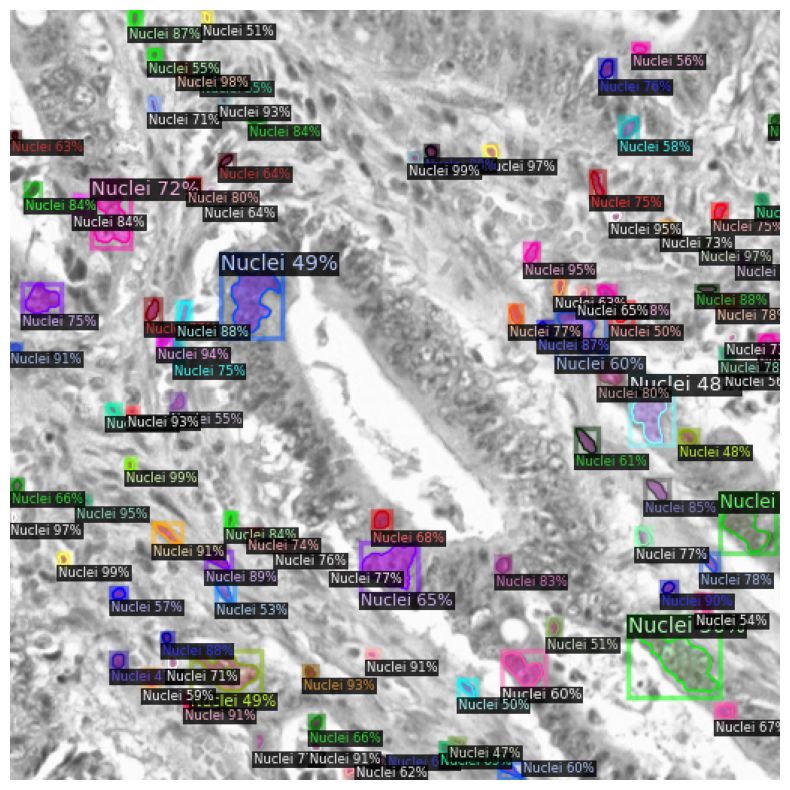

glas_34_0.png


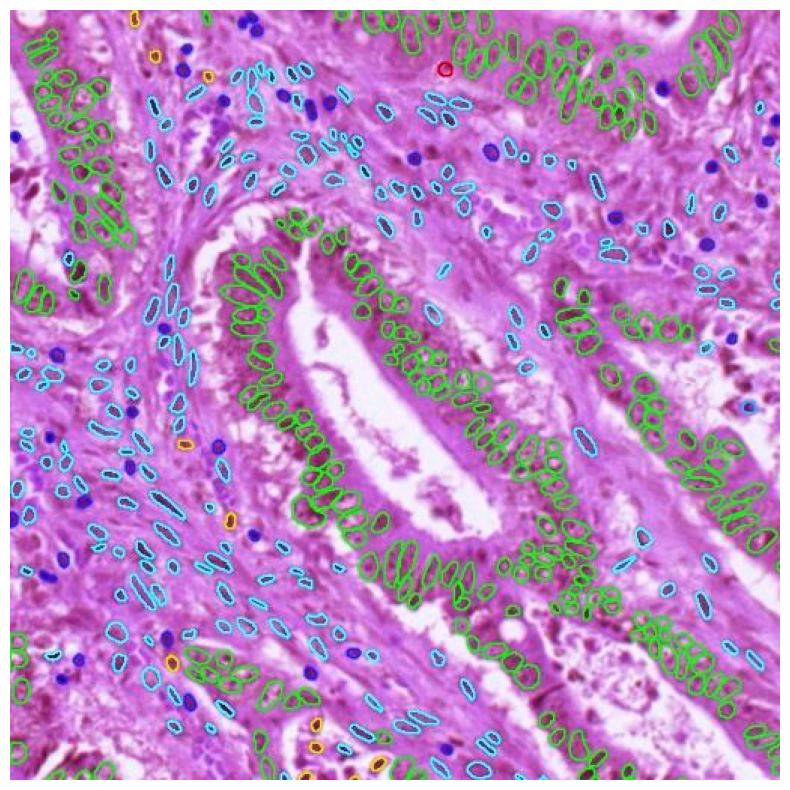

In [22]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # cv2_imshow(im[:, :, ::-1])
    # cv2_imshow(out.get_image()[:, :, ::-1])
    
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

    # compare with the ground truth
    file_name = d["file_name"].split("\\")[-1]
    print(file_name)
    if file_name.endswith(".png"):
        file_name = file_name[:-4] + ".jpg"
    img = cv2.imread(f"D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/overlay/Overlay_patches/{file_name}")
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

You can apply your own threshold to filter objects. But remember that the lowest threshold would be the number set in the cfg setting. Check this line above:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2

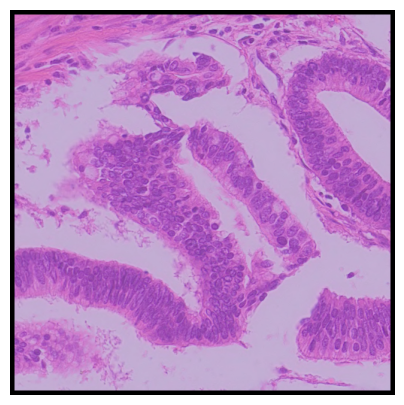

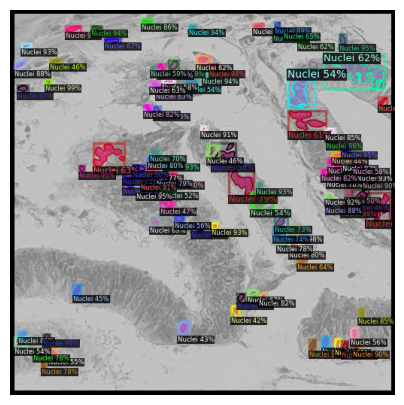

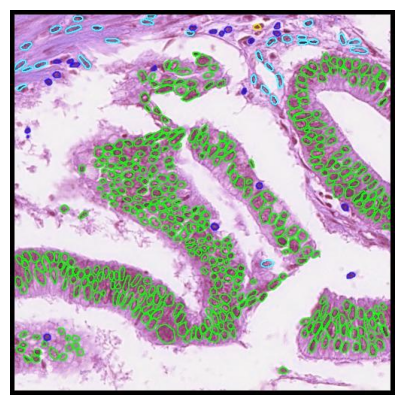

In [24]:
for d in random.sample(test_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs2 = predictor(im)

    # Perform prediction on the tile using your trained model
    outputs2 = predictor(im)

# Get the confidence scores
    scores = outputs2["instances"].scores

# Define your custom threshold
    threshold = 0.1

# Filter instances based on confidence threshold
    filtered_indices = [i for i, score in enumerate(scores) if score > threshold]

# Update the instances in the outputs
    outputs2["instances"] = outputs2["instances"][filtered_indices]

    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs2["instances"].to("cpu"))

    # cv2_imshow(im[:, :, ::-1])
    # cv2_imshow(out.get_image()[:, :, ::-1])

    plt.figure(figsize=(5, 5))
    plt.imshow(im[:, :, ::-1])
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()
    
    # compare with the ground truth
    file_name = d["file_name"].split("\\")[-1]
    if file_name.endswith(".png"):
        file_name = file_name[:-4] + ".jpg"
    img = cv2.imread(f"D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/overlay/Overlay_patches/{file_name}")
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

**Check the segmentation metrics (Average Precision & recall)** <p>
In this example, we have the ground truth masks for our test dataset. If you do not have the ground truth, please use the validation dataset for this part.

In [25]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("dataset_test", output_dir="./output")
test_loader = build_detection_test_loader(cfg, "dataset_test")
print(inference_on_dataset(predictor.model, test_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[05/13 16:30:53 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[05/13 16:30:54 d2.data.datasets.coco]: Loaded 139 images in COCO format from D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/test/coco_annotations.json
[05/13 16:30:54 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Nuclei   | 39599        |
|            |              |
[05/13 16:30:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/13 16:30:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/13 16:30:54 d2.data.common]: Serializing 139 elements to byte tensors and concatenating them all ...
[05/13 16:30:54 d2.data.common]: Serialized dataset takes 4.94 MiB
[05/13 16:30:54 d2.evaluation.evaluator]: Start 

**Understanding the average precision metric:**
<p>

**AP =** Average Precision <br>

**AP50 =** AP calculated using IoU threshold of 0.5. In our case, we got AP50 as 72, which means our model is performing well at this threshold. <br>

**APs (small objects):** Our score is 32 which suggests that the model's performance on small objects is lower than overall performance. <br>

**APm (medium objects):** Our score is 50 suggesting our model performs better on medium objects. <br>

**APl (large objects):** We have NaN. Could mean that we have no large objects.



**Loading a new image and segmenting it.**

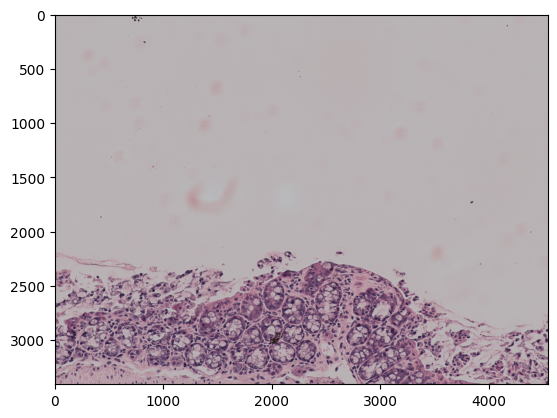

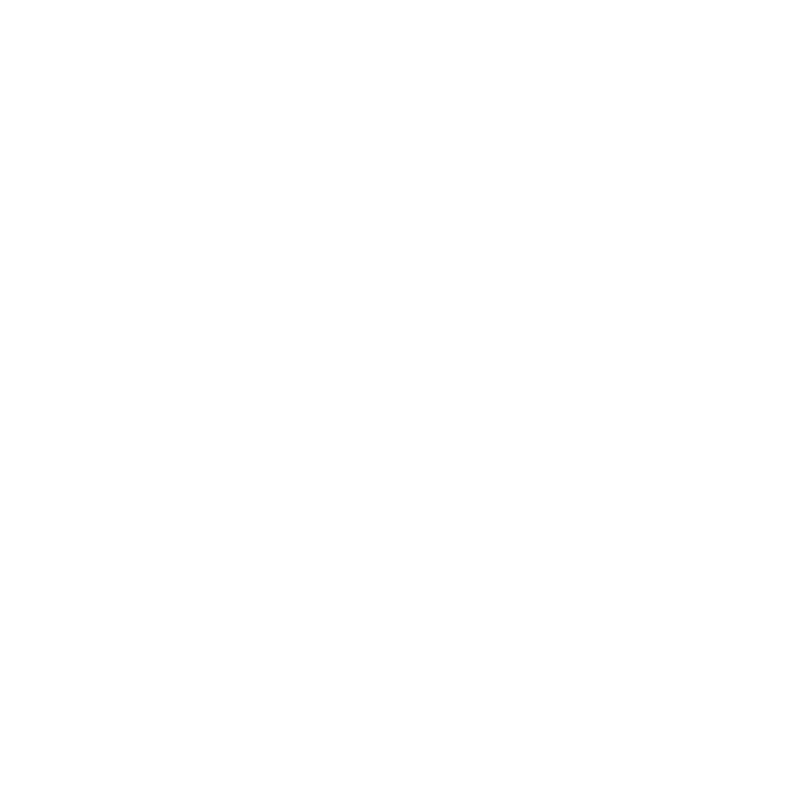

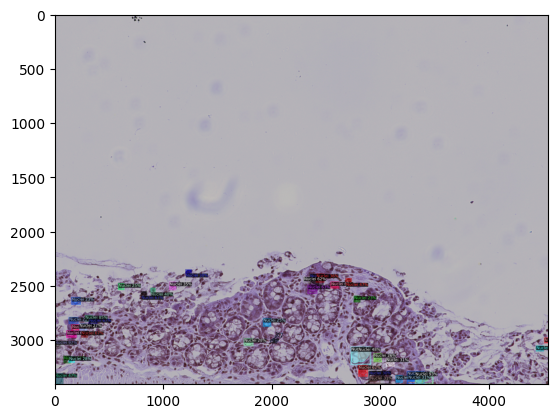

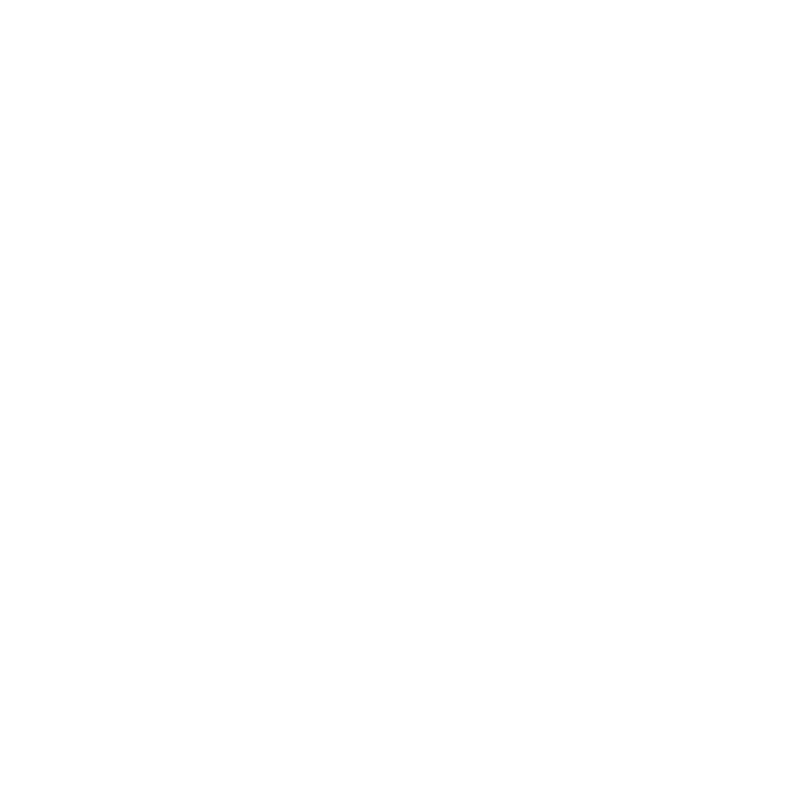

In [29]:
new_im = cv2.imread("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_06_48__T02_S04/ScanArea01/0018.jpg")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# cv2_imshow(new_im[:, :, ::-1])
# cv2_imshow(out.get_image()[:, :, ::-1])

plt.imshow(new_im[:, :, ::-1])
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.show()

plt.imshow(out.get_image()[:, :, ::-1])
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.show()


**Processing multiple images in a directory and saving the results in an output directory**

In [ ]:
'''
Copy test img files
'''

# import shutil
# import os
# from tqdm import tqdm

# source_images_directory = "D:\hjkwak\PROJ_Nuclei_Segmentation\msp-samples"
# subdirectories = ["2024-05-03_09_06_48__T02_S04", "2024-05-03_09_28_20__T02_S12", "2024-05-03_09_36_00__T02_S14"]

# input_images_directory = "D:\hjkwak\PROJ_Nuclei_Segmentation\msp-samples\input_images"
# # if there is no input_images_directory, create one
# if not os.path.exists(input_images_directory):
#     os.makedirs(input_images_directory)

# cnt = 0

# for subdirectory in tqdm(subdirectories):
#     # go to every folder in the source_images_directory + subdirectory
#     # if image file starts with '0', copy the image to the input_images_directory
#     for root, dirs, files in os.walk(os.path.join(source_images_directory, subdirectory)):
#         for file in files:
#             if file.startswith('0'):
#                 # copy the image to the input_images_directory and rename it
#                 shutil.copy(os.path.join(root, file), os.path.join(input_images_directory, file))
#                 # rename the image file
                
#                 new_file_name = os.path.join(root, file)
#                 new_file_name = '_'.join(new_file_name.split('\\')[-3:])
                
#                 os.rename(os.path.join(input_images_directory, file), os.path.join(input_images_directory, new_file_name))
#                 cnt += 1

# print(cnt)

In [ ]:
# check how many files in input_images
print(len(os.listdir("D:\hjkwak\PROJ_Nuclei_Segmentation\msp-samples\input_images")))

In [ ]:
print(len(  os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_06_48__T02_S04/ScanArea01")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_06_48__T02_S04/ScanArea02")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_06_48__T02_S04/ScanArea03")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_28_20__T02_S12/ScanArea01")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_28_20__T02_S12/ScanArea02")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_36_00__T02_S14/ScanArea01")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_36_00__T02_S14/ScanArea02")          
          )
      - 6*7)

In [ ]:
from tqdm import tqdm
import cv2

# Commenting the following code as we often do not need to save segmented images with bounding boxes.
# We need real numbers with object measurements or labeled images as output.


# Directory path to the input images folder
input_images_directory = "D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/input_images"

# Output directory where the segmented images will be saved
output_directory = "D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/output_images"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# List of valid image extensions
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

# Loop over the images in the input folder
for image_filename in tqdm(os.listdir(input_images_directory)):
    # Check if the file has a valid image extension
    if not any(image_filename.lower().endswith(ext) for ext in valid_extensions):
        continue

    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=test_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")


**Segmenting images and saving object level information into a csv file.**




In [ ]:
import csv
from skimage.measure import regionprops, label

In [ ]:
# Assuming you have already defined the 'predictor' object and loaded the model.
# Also, make sure 'metadata' is defined appropriately.

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test"

# Output directory where the CSV file will be saved
output_csv_path = "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test_results/output_objects.csv"

# Extract the directory name from the full path
output_dir_name = os.path.dirname(output_csv_path)

# Check if the directory exists
if not os.path.exists(output_dir_name):
    # If not, create the directory
    os.makedirs(output_dir_name)


# List of valid image extensions.
#If you have non-image files (e.g., json) then you don't want to see an error.
#So it is better to define valid file extensions for our task.
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        # Check if the file has a valid image extension
        if not any(image_filename.lower().endswith(ext) for ext in valid_extensions):
            continue

        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)
        props = regionprops(labeled_mask)

        # Write the object-level information to the CSV file
        for i, prop in enumerate(props):
            object_number = i + 1
            area = prop.area
            centroid = prop.centroid
            bounding_box = prop.bbox

            # Check if the corresponding class label exists
            if i < len(class_labels):
                class_label = class_labels[i]
                class_name = test_metadata.thing_classes[class_label]
            else:
                class_name = 'Unknown'

            csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])

print("Object-level information saved to CSV file.")


**Loading our measurements csv file and generating some plots**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test_results/output_objects.csv')


In [ ]:
# 1. Average number of Nuclei per image for each unique 'File Name'.
# Extract the base name from the file name (excluding the number)
df['Base Name'] = df['File Name'].str.rsplit('_', 1).str[0]

# Group by the base name and compute the average number of nuclei
avg_nuclei_per_base_name = df.groupby('Base Name')['Object Number'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(data=avg_nuclei_per_base_name, x='Base Name', y='Object Number')
plt.title('Average Number of Nuclei per Image Type')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# 2. Average Nuclei area per unique 'File Name'
# Group by the base name and compute the average area
avg_area_per_base_name = df.groupby('Base Name')['Area'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(data=avg_area_per_base_name, x='Base Name', y='Area')
plt.title('Average Nuclei Area per Image Type')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# 3. Distribution of Number of Nuclei by Category (e.g., "human" or "mouse")
df['Category'] = df['File Name'].str.split('_').str[0]

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Category', y='Object Number')
plt.title('Distribution of Number of Nuclei by Category')
plt.show()


In [ ]:
# 4. Average area of Nuclei by Category
avg_area_by_category = df.groupby('Category')['Area'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_area_by_category, x='Category', y='Area')
plt.title('Average Area of Nuclei by Category')
plt.show()

# END

Optional topic - already covered in pevious tutorial - Number 330.

**Saving labeled mask images for each class for further processing.**
<p>
Here, for each input image we will save labeled mask. These masks can be used for further downstream processing.

In [ ]:
import os
import cv2
import numpy as np
from skimage.measure import label
from detectron2.utils.visualizer import Visualizer

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test_results_labeled_masks"


# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    # Check if the file has a .png extension
    if not image_filename.lower().endswith('.png'):
        continue

    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)

    # Convert the predicted mask to a binary mask
    binary_mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(np.uint8)

    # Sum along the third dimension to combine all the masks into one
    combined_mask = np.sum(binary_mask, axis=0)

    # Label the combined mask to give each object a unique integer value
    labeled_mask = label(combined_mask)

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the labeled mask
    cv2.imwrite(output_path, labeled_mask.astype(np.uint16))

print("Segmentation of all images completed.")
